<center><img src="Logolink_OP_VVV_hor_barva_cz.jpg" width="600px"/></center>

#### <center>ESF projekt Západočeské univerzity v Plzni reg. č. CZ.02.2.69/0.0/0.0/16 015/0002287</center>

# KKY/USVP 3

In [70]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Fourier Transform

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import skimage.io
import skimage.transform
from operator import itemgetter

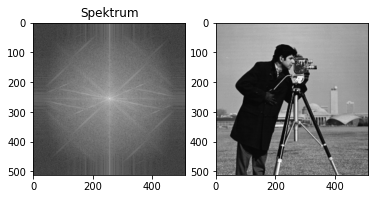

In [72]:
im = data.camera()

ft = np.fft.fft2(im) # 2D Fourier Transform (FT)
ftshift = np.fft.fftshift(ft) # Change quadrants of the FT (1<-->3, 2<-->4)
spek = 20*np.log(np.abs(ftshift)) # Spectrum of FT

# vizualizace
plt.subplot(121)
plt.imshow(spek, cmap = 'gray')
plt.title('Spektrum')

plt.subplot(122)
plt.imshow(im, cmap='gray')

### Example of Fourier transfrom application - scan document deskew algorithm

In [73]:
def deskew_fft(image, range_min=-15, range_max=15, height=2.0, width=3.0):
    """
        Function deskew_fft search in the spectrum centre for the skew angle of the image

        @param image - input image
        @param range_min - minimum searched angle (range_min * 0.1 == angle in degrees, this -15 --> -1.5) 
        @param range_max - maximum searched angle (range_max * 0.1 == angle in degrees, this  15 -->  1.5) 
        @param height - image_height/height -- shrink value of spectrum width 
        @param width - image_width/width -- shrink value of spectrum width 

        @output Found angle
    """
    ft = np.fft.fft2(image)
    ftshift = np.fft.fftshift(ft)
    spek = 20 * np.log(np.abs(ftshift))
    # spectrum center -- it is not efficient to search in whole spectrum
    spect_cent_y = np.uint32(spek.shape[0]/2)
    spect_cent_x = np.uint32(spek.shape[1]/2)
    spect_offset_y = np.uint32(spek.shape[0]/height)
    spect_offset_x = np.uint32(spek.shape[1]/width) 
    spect_center = spek[spect_cent_y-spect_offset_y:spect_cent_y+spect_offset_y,
                    spect_cent_x-spect_offset_x:spect_cent_x+spect_offset_x]
    # Search for max response in spect center
    maxS = 0
    angle = 0
    for i in range(range_min, range_max):
        imr = skimage.transform.rotate(spect_center, i*0.1)
        temp = np.max(np.sum(imr,0))
        if temp > maxS:
            maxS = temp
            angle = i*0.1
    return angle

def rotate(image, angle):
    """
        Function rotate perform image rotation around center by value "angle"

        @param image - input image
        @param angle - rotation angle

        @output - rotated image
    """
    # Creation of bigger image with mean value 
    temp_image = np.ones([image.shape[0] * 2, image.shape[1] * 2], dtype=np.uint8) * np.mean(image)
    ymin = int(temp_image.shape[0] / 2.0 - image.shape[0] / 2.0)
    ymax = int(temp_image.shape[0] / 2.0 + image.shape[0] / 2.0)
    xmin = int(temp_image.shape[1] / 2.0 - image.shape[1] / 2.0)
    xmax = int(temp_image.shape[1] / 2.0 + image.shape[1] / 2.0)
    temp_image[ymin: ymax, xmin: xmax] = image
    # Apply rotation
    temp_image = skimage.transform.rotate(temp_image, angle)
    image = temp_image[ymin: ymax, xmin: xmax]
    return image    

def deskew(image, y_res=(16, 48), x_res=(10, 20), tiles_perct=0.2):
    """
        Function deskew perform searching for angle in multiple tiles of the image

        @param image - input image
        @param y_res - border and tile size y
        @param x_res - border and tile size x
        @param tiles_perct - percentage of tiles that is used for angle searching
    """
    tiles = []
    border_y = int(image.shape[0]/y_res[0])
    border_x = int(image.shape[1]/x_res[0])
    tile_height = int(image.shape[0]/y_res[1])
    tile_width = int(image.shape[1]/x_res[1])
    for y in range(0 , image.shape[0] - border_y, tile_height):
        y2 = y + border_y
        for x in range(0, image.shape[1] - border_x, tile_width):
            x2 = x + border_x
            tiles.append((y, y2, x, x2, np.mean(image[y:y2, x:x2])))
    tiles.sort(key=itemgetter(4))
    n = int(len(tiles)*tiles_perct)
    angle_mean = 0
    angle = 0
    for i in range(n):
        y = tiles[i][0]
        y2 = tiles[i][1]
        x = tiles[i][2] 
        x2 = tiles[i][3]
        part = image[y:y2, x:x2]
        angle = deskew_fft(part)
        angle_mean = angle_mean + angle
    return angle_mean/ float(n)

def apply_deskew(image):
    """
        Function apply_deskew applies deskew algorithm

        @param image - input image
        @output image_deskew - rotated image
        @output angle - found angle
    """
    angle = 0.0
    if len(image.shape) == 2:
        angle = deskew(image)    
        image_deskew = rotate(image, angle)
    elif len(image.shape) == 3:
        angle_r = deskew(image[:, :, 0])    
        angle_g = deskew(image[:, :, 1])    
        angle_b = deskew(image[:, :, 2])    
        angle = (angle_r + angle_g + angle_b)/3.0
        image_deskew_r = rotate(image[:, :, 0], angle)  
        image_deskew_g = rotate(image[:, :, 1], angle)    
        image_deskew_b = rotate(image[:, :, 2], angle)    
        image_deskew = np.dstack([image_deskew_r, image_deskew_g, image_deskew_b])    
    else:
        print("Vstup musi byt RGB nebo sedotonovy obraz")
    return image_deskew, angle

1.035393258426969


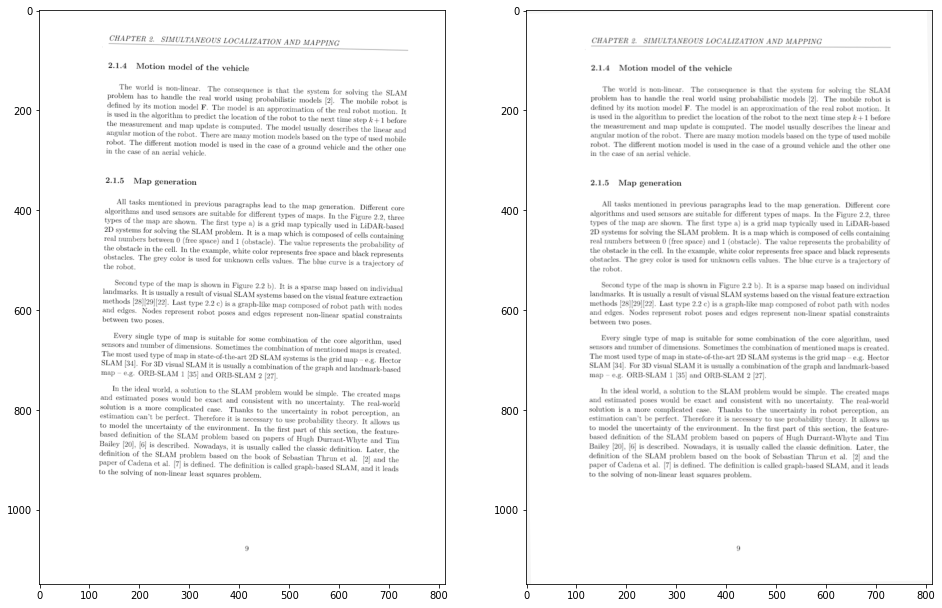

In [74]:
skewed_scan = skimage.io.imread("./cviceni_3/download.png", as_gray=True)
deskewed_scan, angle = apply_deskew(skewed_scan)
print(angle)

plt.figure(1, figsize=(16,16))
plt.subplot(121)
plt.imshow(skewed_scan, cmap = 'gray')
plt.subplot(122)
plt.imshow(deskewed_scan, cmap = 'gray')


## Mathematical Morphology

### Dilation

In [75]:
import numpy as np

def dilate(image, element):
    """
        Binary dilation function

        @param image - input image
        @param element - element
    """
    result = np.zeros(image.shape, dtype=np.uint8)
    indexes = np.where(image == 1)
    elements = np.where(element == 1)
    for y,x in zip(indexes[0], indexes[1]):
        res0 = y + elements[0]
        res1 = x + elements[1]
        result[res0, res1] = 1
    return result

#### Example

In [76]:
img = np.zeros([7,7])
img[2:4,2:3] = 1
print(img)

elem = np.zeros([2,2])
elem[:,0] = 1
elem[1,1] = 1

print(elem)

res_im = dilate(img, elem)
print(res_im)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[1. 0.]
 [1. 1.]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


### Erosion

In [77]:
def erode(image, element):
    """
        Binary erosion function

        @param image - input image
        @param element - element
    """    
    result = np.zeros(image.shape, dtype=np.uint8)
    indexes = np.where(image == 1)
    elements = np.where(element == 1)
    for y,x in zip(indexes[0], indexes[1]):
        res = [1 - item for item in image[y+elements[0], x+elements[1]].ravel()]
        if(sum(res) == 0):
            result[y, x] = 1
    return result

#### Example

In [78]:
erosion_res = erode(res_im, elem)
print(erosion_res)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


### Opening and Closing

In [79]:
def morph_open(image, elem):
    """
        Binary opening function

        @param image - input image
        @param element - element
    """ 
    res1 = erode(image, elem)
    res2 = dilate(res01, elem)
    return res2

def morph_close(image, elem):
    """
        Binary closing function

        @param image - input image
        @param element - element
    """     
    res1 = dilate(image, elem)
    res2 = erode(res01, elem)
    return res2    